# Import Libraries



In [1]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load datasets

In [2]:
train_df = pd.read_csv('aug_train.csv')
test_df = pd.read_csv('aug_test.csv')

# Data Cleaning

In [17]:
# Handling datatype

train_df['city_development_index'] = train_df['city_development_index'] * 100
test_df['city_development_index'] = test_df['city_development_index'] * 100

test_df['city'] = test_df['city'].astype(str)
train_df['city'] = train_df['city'].astype(str)

test_df['company_size'] = test_df['company_size'].astype(str)
train_df['company_size'] = train_df['company_size'].astype(str)

train_df['experience'] = train_df['experience'].replace({'>20': '22', '<1': 0}).astype(float)
test_df['experience'] = test_df['experience'].replace({'>20': '22', '<1': 0}).astype(float)

train_df['last_new_job'] = train_df['last_new_job'].replace({'>4': 5,'never':0}).astype(float)
test_df['last_new_job'] = test_df['last_new_job'].replace({'>4': 5,'never':0}).astype(float)


#NAN-Treatment code

# Apply transformation to 'experience'
train_df['experience'] = train_df['experience'].replace('22', 23).astype(float)
train_df['experience'] = np.log1p(train_df['experience'])
test_df['experience'] = test_df['experience'].replace('22', 23).astype(float)
test_df['experience'] = np.log1p(test_df['experience'])

# Apply transformation to 'last_new_job'
train_df['last_new_job'] = train_df['last_new_job'].replace('5', 5.5).astype(float)
train_df['last_new_job'] = np.log1p(train_df['last_new_job'])
test_df['last_new_job'] = test_df['last_new_job'].replace('5', 5.5).astype(float)

In [18]:
train_df['company_size'].value_counts()

,count
company_size,
0.4075094729590079,5806
0.17707985299031073,2993
0.16074990027921818,2507
0.19074262461851474,1966
0.23619846261355695,1431
0.14615384615384616,1300
0.17176470588235293,1275
0.1750291715285881,857
0.18165467625899281,556


In [19]:
# Drop unwanted columns
train_df = train_df.drop(columns=[ 'city'], errors='ignore')
test_df = test_df.drop(columns=[ 'city'], errors='ignore')

# Data Visualization



In [20]:
def descriptive_statistics(df):
    print("Numerical Columns Statistics:")
    print(df.describe())
    print("\nCategorical Columns Statistics:")
    print(df.describe(include=['object']))

descriptive_statistics(train_df)
descriptive_statistics(test_df)

Numerical Columns Statistics:
        enrollee_id  city_development_index  relevent_experience  \
count  18691.000000            18691.000000         18691.000000   
mean   16874.411053             8292.862340             0.279921   
std     9614.694094             1228.333498             0.448972   
min        1.000000             4790.000000             0.000000   
25%     8562.500000             7400.000000             0.000000   
50%    16993.000000             9030.000000             0.000000   
75%    25169.500000             9200.000000             1.000000   
max    33380.000000             9490.000000             1.000000   

       education_level    experience  last_new_job  training_hours  \
count     18691.000000  18627.000000  18278.000000    18691.000000   
mean          0.249960      2.178182      0.947198       59.918035   
std           0.040511      0.765170      0.555971       49.060202   
min           0.136213      0.000000      0.000000        1.000000   
25%    

In [21]:
# Checking for null values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()
missing_percent_train = (missing_values_train / len(train_df)) * 100
print("Missing Values in Train Dataset:\n")
for col, missing_count in missing_values_train.items():
    missing_percent = missing_percent_train[col]
    print(f"{col}: {missing_count} ({missing_percent:.2f}%)")
print("\nMissing Values in Test Dataset:")
print(missing_values_test)


Missing Values in Train Dataset:

enrollee_id: 0 (0.00%)
city_development_index: 0 (0.00%)
relevent_experience: 0 (0.00%)
education_level: 0 (0.00%)
experience: 64 (0.34%)
company_size: 0 (0.00%)
last_new_job: 413 (2.21%)
training_hours: 0 (0.00%)
target: 0 (0.00%)
gender_Male: 0 (0.00%)
gender_Other: 0 (0.00%)
enrolled_university_Part time course: 0 (0.00%)
enrolled_university_no_enrollment: 0 (0.00%)
major_discipline_Business Degree: 0 (0.00%)
major_discipline_Humanities: 0 (0.00%)
major_discipline_No Major: 0 (0.00%)
major_discipline_Other: 0 (0.00%)
major_discipline_STEM: 0 (0.00%)
company_type_Funded Startup: 0 (0.00%)
company_type_NGO: 0 (0.00%)
company_type_Other: 0 (0.00%)
company_type_Public Sector: 0 (0.00%)
company_type_Pvt Ltd: 0 (0.00%)

Missing Values in Test Dataset:
enrollee_id                              0
city_development_index                   0
relevent_experience                      0
education_level                          0
experience                         

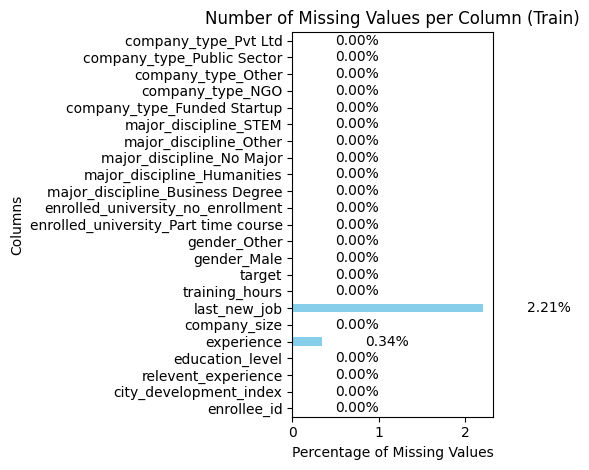

In [22]:
# Visualizing missing values
# Plot the missing values
ax = missing_percent_train.plot.barh(color='skyblue')

# Add percentage labels at the end of each bar
for index, value in enumerate(missing_percent_train):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.title('Number of Missing Values per Column (Train)')
plt.ylabel('Columns')
plt.xlabel('Percentage of Missing Values')
plt.tight_layout()
plt.show()

## Null Value Treatment

In [24]:

# Columns to fill using mode
# Ensure the column names in 'columns_mode_fill' match the actual column names in your DataFrame
columns_mode_fill = ['experience', 'company_type', 'gender', 'major_discipline', 'education_level', 'enrolled_university']
for col in columns_mode_fill:
    # Check if the column exists before trying to fill NaN values
    if col in train_df.columns:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping NaN filling for this column.")

# Fill 'last_new_job' using probability distribution (excluding '1')
job_dist = train_df[train_df['last_new_job'].notnull() & (train_df['last_new_job'] != 1)]['last_new_job'].value_counts(normalize=True)
train_df.loc[train_df['last_new_job'].isnull(), 'last_new_job'] = np.random.choice(
    job_dist.index,
    size=train_df['last_new_job'].isnull().sum(),
    p=job_dist.values
)

# Fill 'company_size' using weighted random sampling
valid_categories = ['TinyScale', 'SmallScale', 'Corporate', 'Emerging_SmallScale',
                    'MediumScale', 'Emerging_TinyScale', 'Intermediate-MediumScale', 'LargeScale']
probabilities = [0.34, 0.28, 0.17, 0.10, 0.05, 0.04, 0.02, 0.01]  # Adjusted based on category distribution

# Normalize probabilities to ensure they sum to 1
probabilities = np.array(probabilities)  # Convert to NumPy array for easier calculations
probabilities /= probabilities.sum()  # Normalize by dividing by the sum

train_df.loc[train_df['company_size'].isnull(), 'company_size'] = np.random.choice(
    valid_categories,
    size=train_df['company_size'].isnull().sum(),
    p=probabilities
)

# Cleaned Datasets

In [25]:
# Save cleaned datasets
train_df.to_csv('cleaned_train.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)



# Exploratory Data Analysis (EDA)

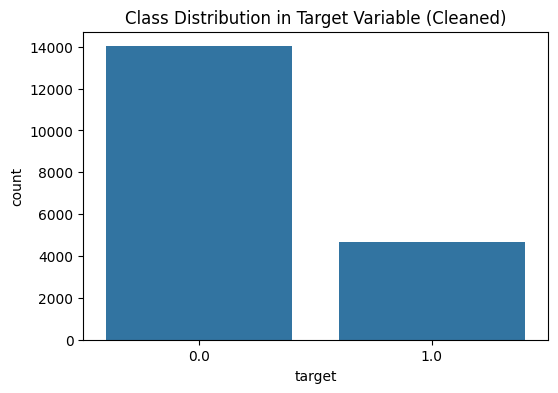

In [26]:
# Check Data Imbalance using cleaned dataset
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['target'])
plt.title('Class Distribution in Target Variable (Cleaned)')
plt.show()



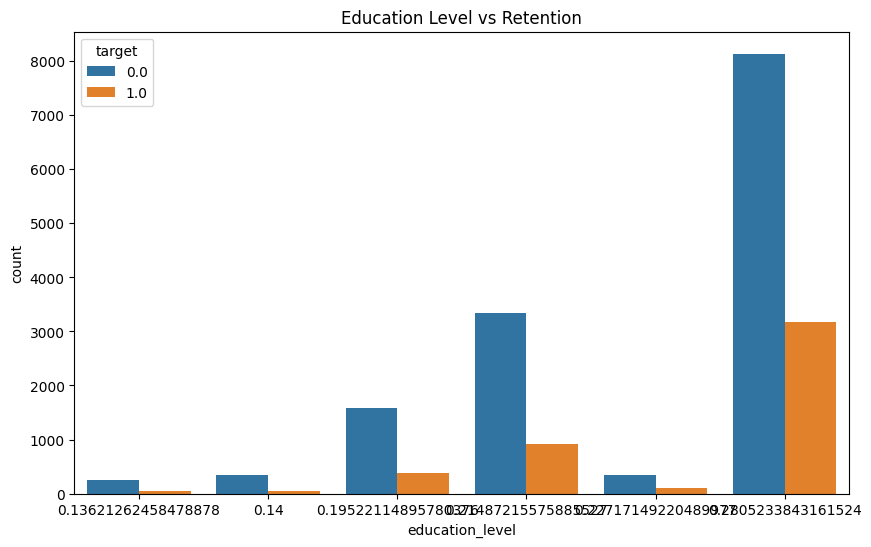

In [27]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')
plt.title('Education Level vs Retention')
plt.show()



<Axes: xlabel='education_level', ylabel='count'>

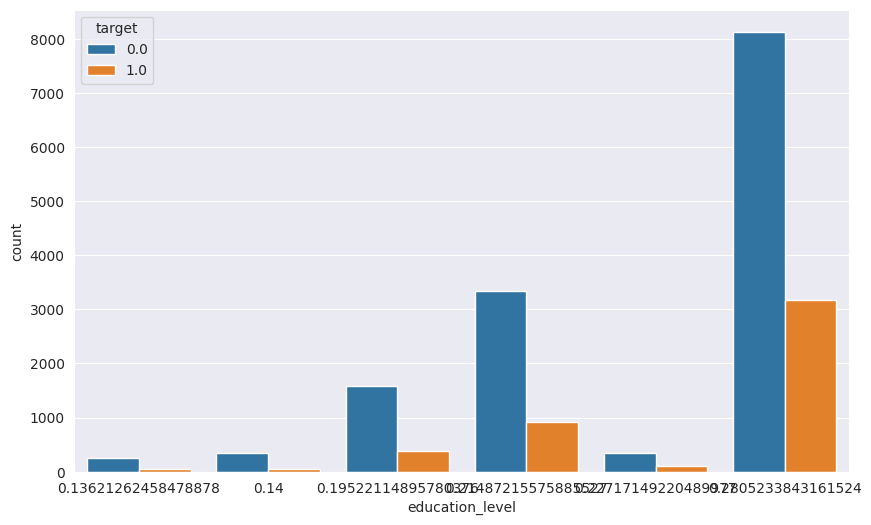

In [29]:
# Data Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')



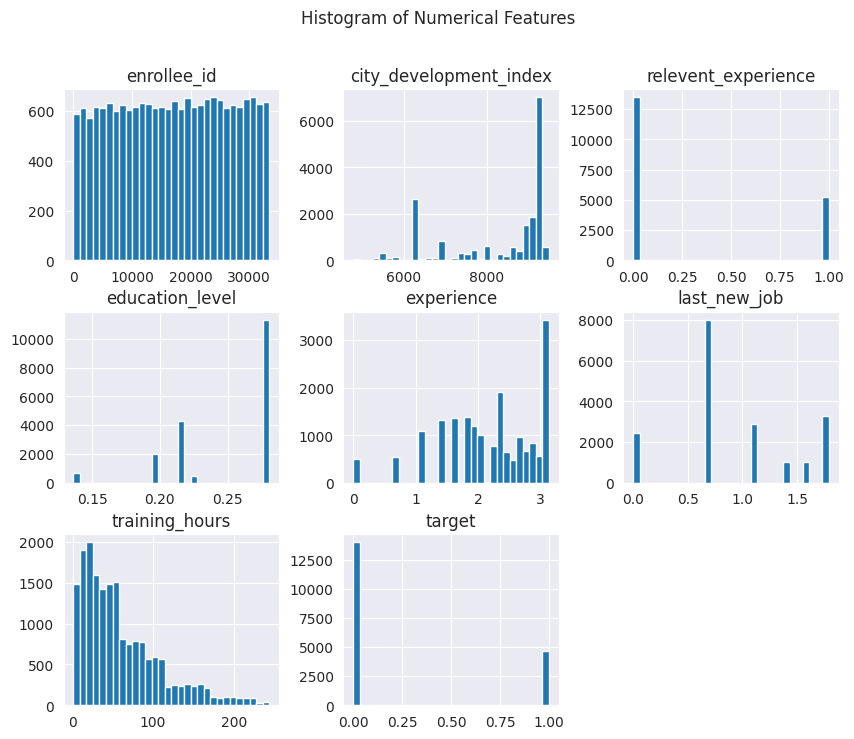

In [30]:
# Histogram for numerical columns
train_df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Histogram of Numerical Features")
plt.show()



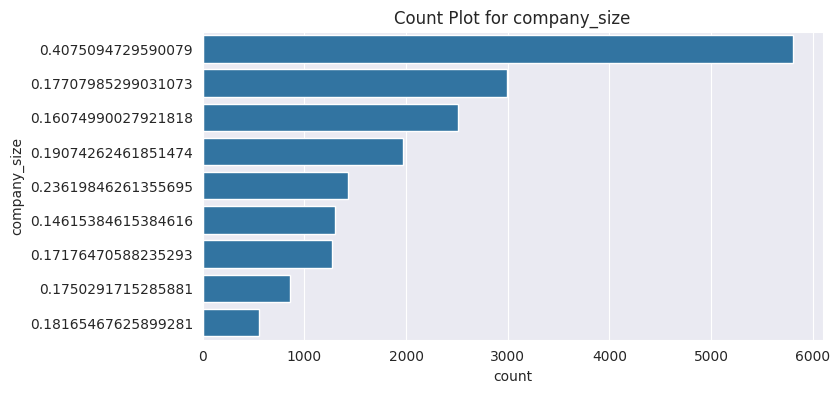

In [31]:
# Count plots for categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(f"Count Plot for {col}")
    plt.show()



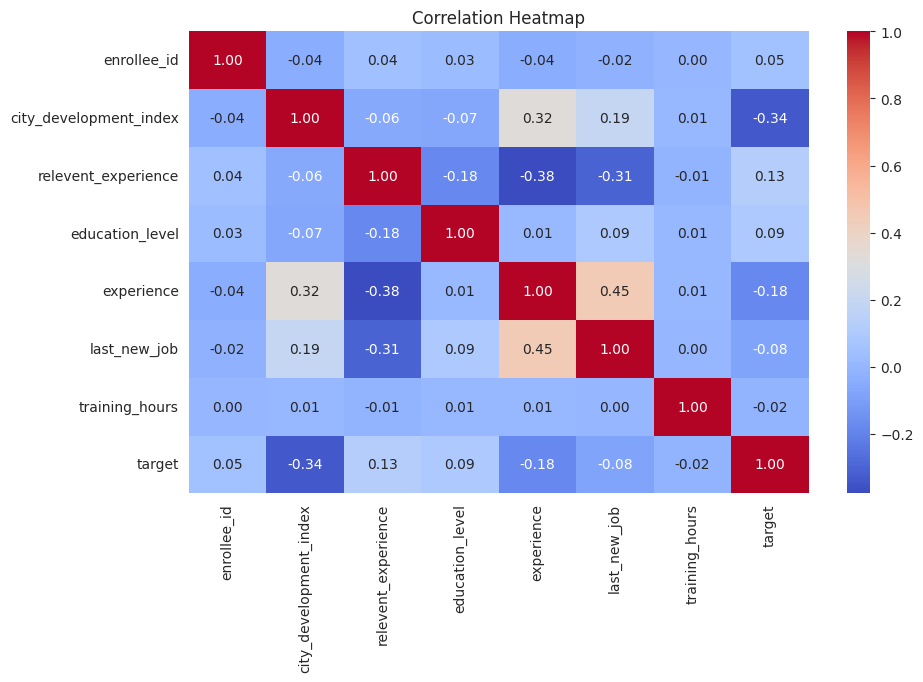

In [32]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
# Select only numerical columns for correlation calculation
numerical_df = train_df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


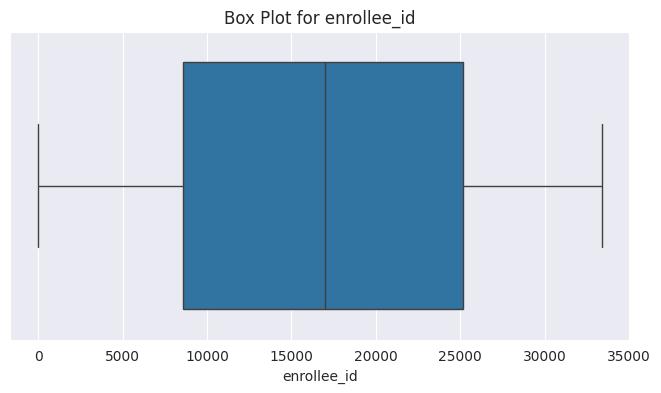

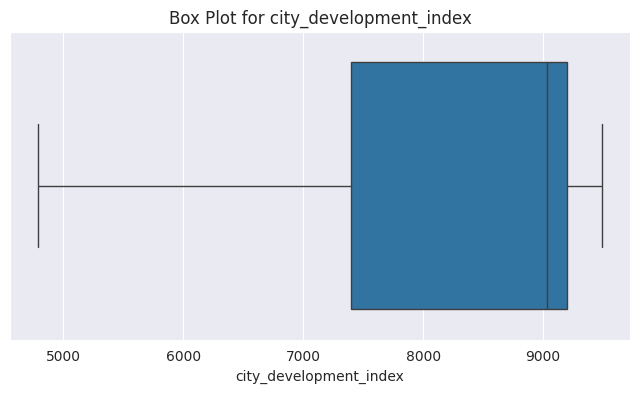

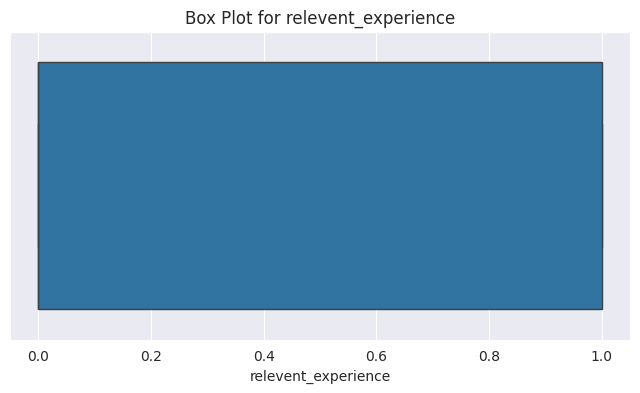

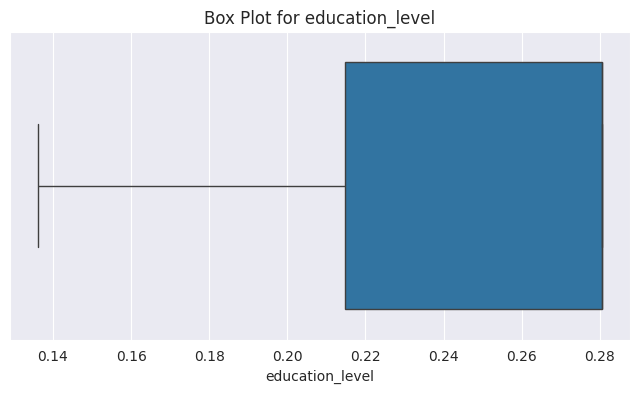

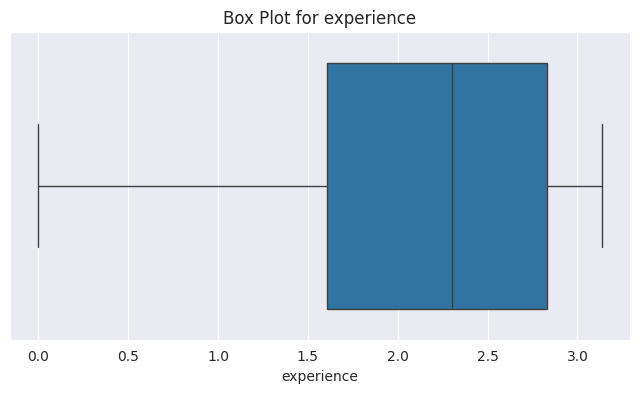

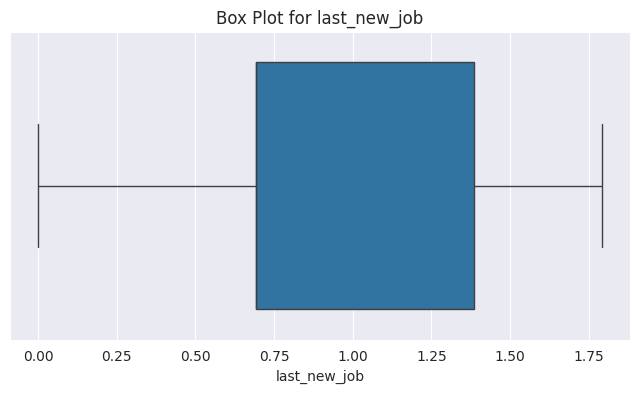

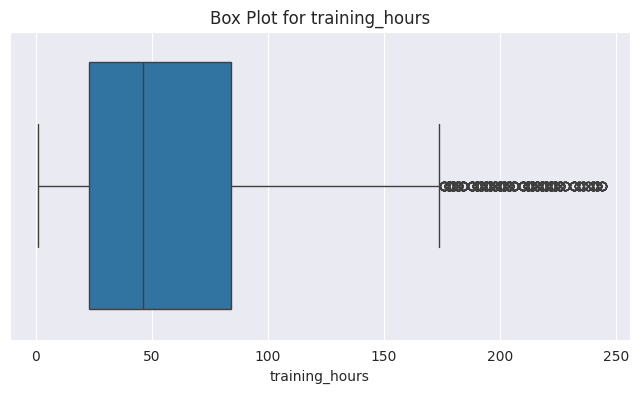

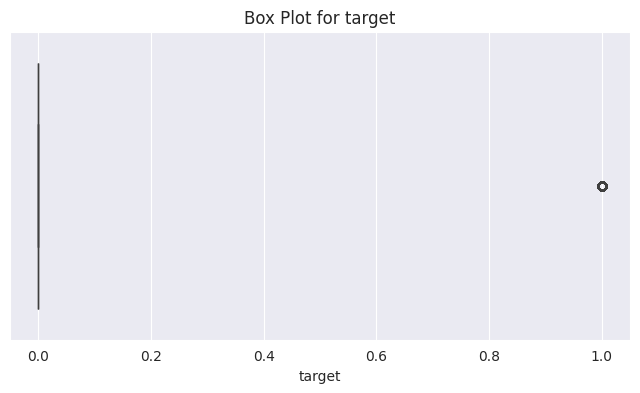

In [33]:
# Box plots for outliers detection
numerical_columns = train_df.select_dtypes(include=['number']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f"Box Plot for {col}")
    plt.show()

In [34]:
# Outlier Detection using Z-score
from scipy.stats import zscore
train_df_numeric = train_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(train_df_numeric))
train_df = train_df[(z_scores < 3).all(axis=1)]
print("Shape after removing outliers:", train_df.shape)

Shape after removing outliers: (18420, 23)


# Outlier Treatment

In [39]:
# Label Encoding for Binary Columns
le = LabelEncoder()
train_df['relevent_experience'] = le.fit_transform(train_df['relevent_experience'])
test_df['relevent_experience'] = le.transform(test_df['relevent_experience'])  # Use the same encoder for test data



In [40]:
# Outlier Detection using Z-score
from scipy.stats import zscore
train_df_numeric = train_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(train_df_numeric))
train_df = train_df[(z_scores < 3).all(axis=1)] # Update train_df after removing outliers
print("Shape after removing outliers:", train_df.shape)

# Outlier Treatment
for col in train_df_numeric.columns:
    Q1 = train_df_numeric[col].quantile(0.25)
    Q3 = train_df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Update the original train_df with treated values
    train_df.loc[train_df.index, col] = np.where(train_df[col] < lower_bound, lower_bound, train_df[col])
    train_df.loc[train_df.index, col] = np.where(train_df[col] > upper_bound, upper_bound, train_df[col])



Shape after removing outliers: (18241, 23)


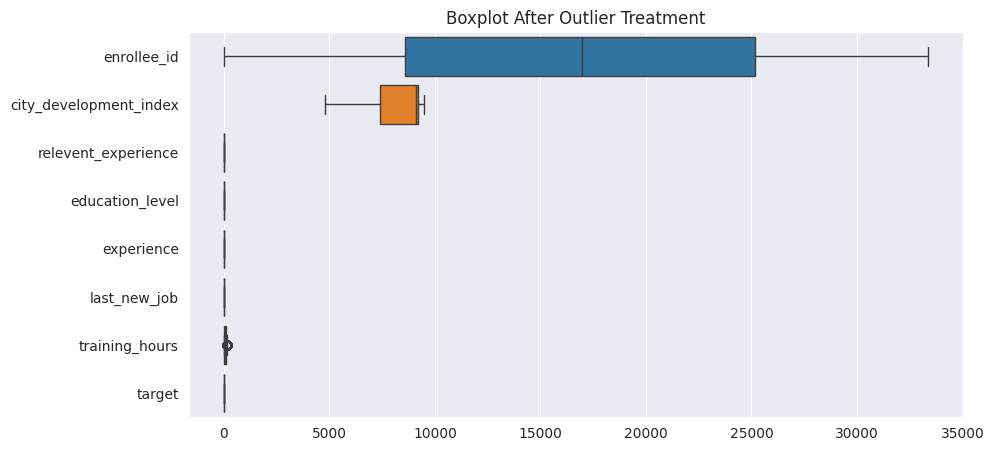

In [41]:
# Boxplot to visualize treated outliers
plt.figure(figsize=(10, 5))  # Adjust figure size for horizontal layout
sns.boxplot(data=train_df.select_dtypes(include=[np.number]), orient='h')  # Set orient to 'h'
plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.title('Boxplot After Outlier Treatment')
plt.show()



In [43]:
# One-Hot Encoding for Nominal Columns (No natural order)
# Check which columns are present in the DataFrame before applying one-hot encoding
one_hot_columns = ['gender', 'enrolled_university', 'major_discipline', 'company_type']
existing_columns = [col for col in one_hot_columns if col in train_df.columns]

# Apply one-hot encoding only to the existing columns
train_df = pd.get_dummies(train_df, columns=existing_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=existing_columns, drop_first=True) #This line uses updated train_df

# Encoding

# Splitting Test & Train

In [44]:
# Splitting data into train and test
X = train_df.drop(columns=['target'])
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# SMOTE - (Synthetic Minority Over-sampling Technique)

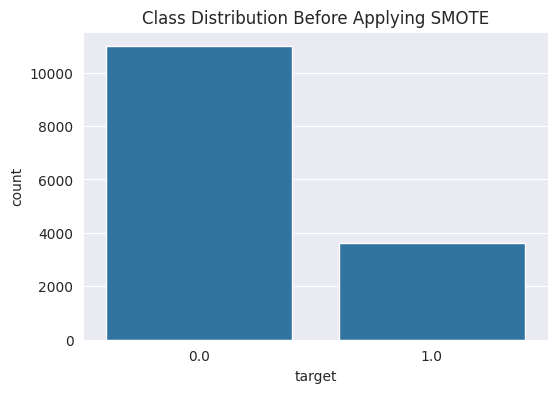

In [45]:
# Check Data Imbalance before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before Applying SMOTE')
plt.show()



In [46]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Model Building

In [47]:
# Hyperparameter tuning settings (example parameters, modify as needed)
param_grid = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
    },
    'LightGBM': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
    }
}


Training Logistic Regression...


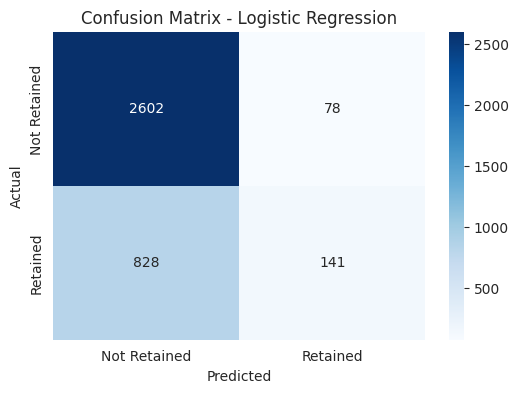

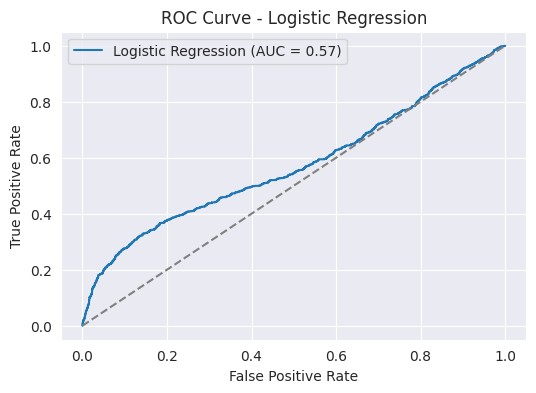

Logistic Regression Accuracy: 0.75, F1 Score: 0.24, Precision: 0.64, AUC: 0.57

Training Decision Tree...


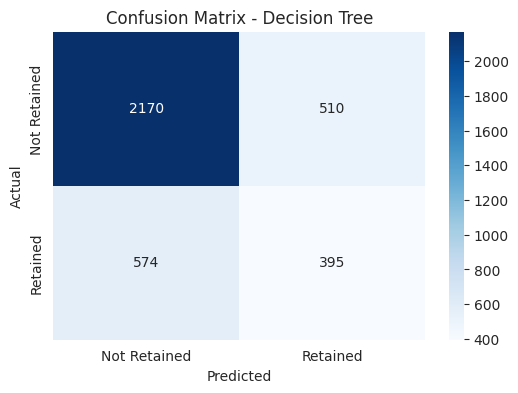

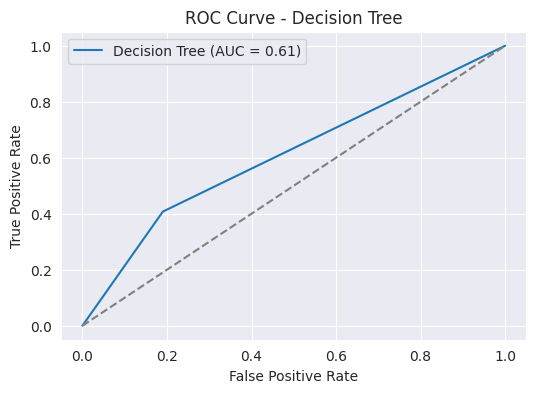

Decision Tree Accuracy: 0.70, F1 Score: 0.42, Precision: 0.44, AUC: 0.61

Training Random Forest...


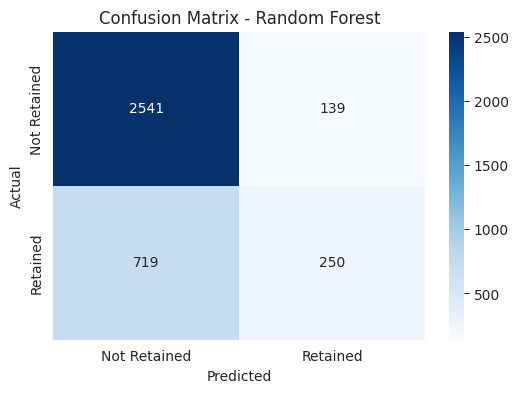

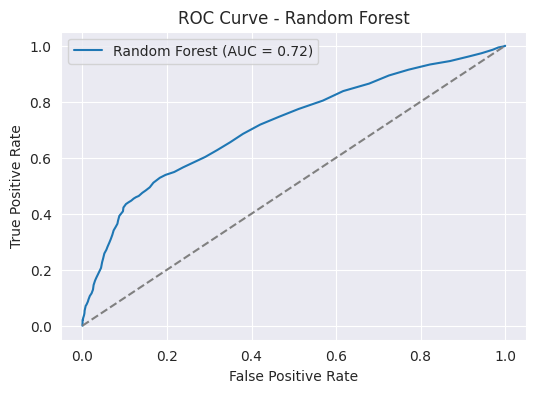

Random Forest Accuracy: 0.76, F1 Score: 0.37, Precision: 0.64, AUC: 0.72

Training XGBoost...


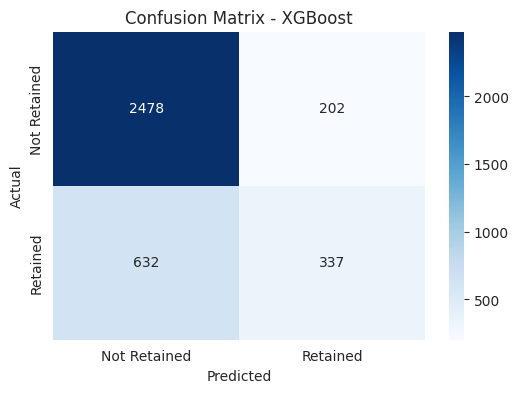

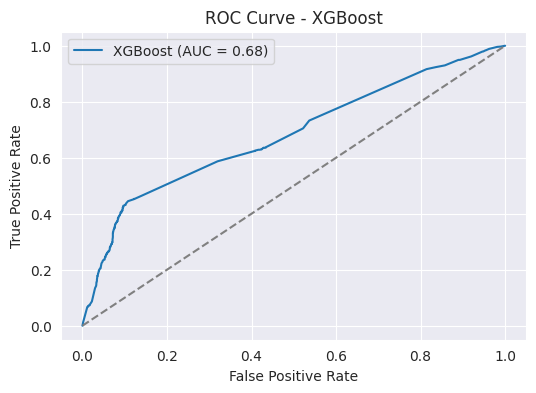

XGBoost Accuracy: 0.77, F1 Score: 0.45, Precision: 0.63, AUC: 0.68

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7320, number of negative: 7321
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 14641, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499966 -> initscore=-0.000137
[LightGBM] [Info] Start training from score -0.000137
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7321, number of negative: 7320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_row

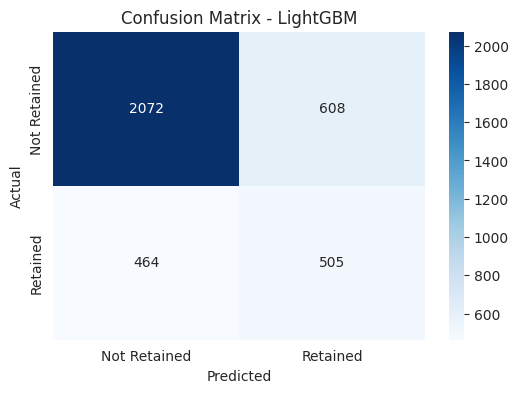

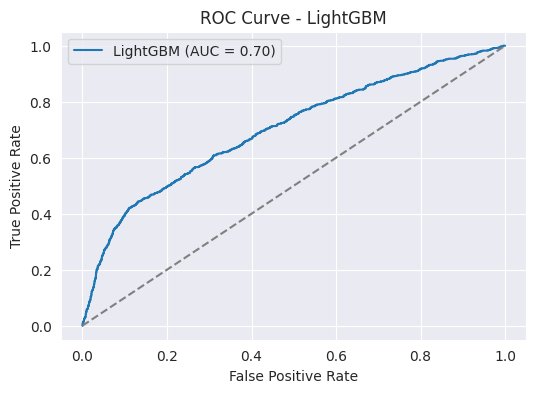

LightGBM Accuracy: 0.71, F1 Score: 0.49, Precision: 0.45, AUC: 0.70


In [52]:
# Building ML Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Convert 'company_size' to numerical before fitting for both X_train and X_test
    X_train_encoded = X_train.copy()  # Create a copy to avoid modifying the original DataFrame
    X_train_encoded['company_size'] = X_train_encoded['company_size'].astype('category').cat.codes
    X_test_encoded = X_test.copy()  # Create a copy of X_test
    X_test_encoded['company_size'] = X_test_encoded['company_size'].astype('category').cat.codes  # Apply the same encoding to X_test


    if name in param_grid:
        # Use RandomizedSearchCV instead of GridSearchCV if you want to use n_iter
        search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=3, scoring='accuracy', n_iter=5, random_state=42)

        search.fit(X_train_encoded, y_train)  # Fit with the encoded data
        model = search.best_estimator_
    else:
        model.fit(X_train_encoded, y_train) # Use encoded data for training as well

    # Use the encoded X_test for prediction
    y_pred = model.predict(X_test_encoded)  # Predict using the encoded X_test
    y_pred_prob = model.predict_proba(X_test_encoded)[:, 1] if hasattr(model, 'predict_proba') else None  # Use encoded X_test

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Retained', 'Retained'], yticklabels=['Not Retained', 'Retained'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve & AUC Score
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_score = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    else:
        auc_score = None

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'AUC': auc_score}
    print(f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, AUC: {auc_score:.2f}' if auc_score else f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}')

In [53]:
# Display summary results
df_results = pd.DataFrame(results).T
print("\nModel Performance Summary")
print(df_results)


Model Performance Summary
                     Accuracy  F1 Score  Precision       AUC
Logistic Regression  0.751713  0.237374   0.643836  0.572855
Decision Tree        0.702932  0.421558   0.436464  0.608669
Random Forest        0.764867  0.368189   0.642674  0.715913
XGBoost              0.771444  0.446950   0.625232  0.681401
LightGBM             0.706221  0.485110   0.453729  0.701261


# Submission